# Notebook 2 - Mapa Geológico Preditivo

### Pré-processamento, modelagem dos dados & validação dos modelos

##### Trabalho de Conclusão de Curso - Geologia / IGC / UFMG

Autores: [Franco Naghetini](https://github.com/fnaghetini) & [Guilherme Silveira](https://github.com/guiasilveira)

<a id='1'></a>
##  Configurações iniciais

##### Importação de bibliotecas

In [1]:
# bibliotecas base
from math import ceil                                        # arredondamento de float para int
import numpy as np                                           # operações numéricas de vetores
import pandas as pd                                          # manipulação de dataframes e series
from sklearn.base import clone                               # criação de clones de classificadores
from imblearn.pipeline import Pipeline                       # criação de pipelines

# bibliotecas de visualização
import matplotlib.pyplot as plt                              # visualização de dados
import seaborn as sns                                        # visualização de dados

# pré-processamento
from sklearn.preprocessing import StandardScaler             # escalonamento dos dados
from sklearn.preprocessing import MinMaxScaler               # escalonamento dos dados
from sklearn.preprocessing import RobustScaler               # escalonamento dos dados
from sklearn.feature_selection import SelectKBest            # feature selection
from sklearn.feature_selection import f_classif              # feature selection
from sklearn.feature_selection import mutual_info_classif    # feature selection
from imblearn.over_sampling import SMOTE                     # algoritmo de oversampling

# modelagem
from sklearn.linear_model import LogisticRegression          # Regressão Logística
from sklearn.naive_bayes import GaussianNB                   # Gaussian Naive Bayes
from sklearn.neighbors import KNeighborsClassifier           # KNN
from sklearn.svm import SVC                                  # SVM
from sklearn.ensemble import RandomForestClassifier          # Random Forest
from xgboost import XGBClassifier                            # XGBoost Classifier

# validação
from sklearn.model_selection import cross_val_score          # scores de validação cruzada
from sklearn.model_selection import StratifiedKFold          # amostragem estratificada
from sklearn.model_selection import RepeatedStratifiedKFold  # k-fold estratificado com múltiplas realizações
from sklearn.metrics import accuracy_score                   # métrica acurácia
from sklearn.metrics import f1_score                         # métrica f1-score
from sklearn.metrics import precision_score                  # métrica de precisão
from sklearn.metrics import recall_score                     # métrica de revocação
from sklearn.metrics import confusion_matrix                 # métrica de matriz de confusão
from sklearn.metrics import classification_report            # report de métricas de classificação

# tuning
from sklearn.model_selection import GridSearchCV             # tuning de hiperparâmetros

import warnings                                              # desabilitar avisos
warnings.filterwarnings("ignore")

%matplotlib inline

##### Importação do banco de dados

In [2]:
df_original = pd.read_csv("data/data_nb2.csv",sep=",")

In [3]:
# criação de uma cópia (deep) do dataframe original
df = df_original.copy(deep = True)

##### Visualização das primeiras linhas do banco de dados

In [4]:
df.head(10)

,X,Y,GT,K,TH,U,CT,U_K,TH_K,U_TH,...,B06,B07,B08,B09,R,G,B,TARGET,UNID,COD
0,638663.68,7981552.08,0.076001,0.38,3.98,2.21,3.56,3.11,6.51,0.49,...,15656,11371,7669,5089,208,199,185,6,Fm_GM,PP4egm
1,638663.68,7981489.58,0.054137,0.41,3.66,2.44,3.60,3.11,6.91,0.47,...,17906,13743,8706,5077,195,189,169,6,Fm_GM,PP4egm
2,638726.18,7981489.58,0.071591,0.57,5.30,2.63,4.23,2.72,6.97,0.41,...,17693,13716,8699,5083,197,160,153,6,Fm_GM,PP4egm
3,638788.68,7981489.58,0.055794,0.80,7.26,2.88,4.92,2.40,7.16,0.36,...,16064,11973,8334,5083,226,208,202,6,Fm_GM,PP4egm
4,638851.18,7981489.58,0.033372,1.05,9.20,3.17,5.54,2.21,7.50,0.33,...,15789,11648,8081,5085,161,167,130,6,Fm_GM,PP4egm
5,638788.68,7981427.08,0.028260,0.85,6.60,2.97,4.92,2.51,7.64,0.36,...,15269,11403,8028,5079,142,107,106,6,Fm_GM,PP4egm
6,638663.68,7981427.08,0.051313,0.44,3.20,2.62,3.62,3.14,7.37,0.44,...,18497,14848,9045,5091,226,175,200,6,Fm_GM,PP4egm
7,638726.18,7981427.08,0.047716,0.62,4.74,2.80,4.25,2.80,7.47,0.40,...,16202,12264,8508,5097,170,107,122,6,Fm_GM,PP4egm
8,638663.68,7981364.58,0.048052,0.49,2.99,2.77,3.63,3.18,7.87,0.42,...,17907,14332,8848,5082,224,150,198,6,Fm_GM,PP4egm
9,638726.18,7981364.58,0.044078,0.64,4.20,2.87,4.23,2.87,7.93,0.38,...,15765,11898,8060,5098,243,171,217,6,Fm_GM,PP4egm


<a id='2'></a>
## Variáveis Globais & funcões auxiliares

##### Variáveis globais

In [5]:
# coordenadas
COORD = ['X','Y']

# features
FEAT = df.columns[2:-3]

# features geofísicas
GF = FEAT[:8]

# canais radiométricos
RADIO = ['K','TH','U']

# sensores remotos
SR = FEAT[8:21]

# meta dados
META = ['UNID','COD']

# dicionário litoestratigráfico
dic_lith = {}
for k, v1, v2 in zip(df['TARGET'].unique(), df['UNID'].unique(), df['COD'].unique()):
    dic_lith[k] = [v1, v2]

##### Parâmetros dos gráficos

In [6]:
# fonte: Times New Roman, tamanho: 12
plt.rcParams.update({'font.family':'Times New Roman', 'font.size' : 12})

fs_title =  16        # tamanho da fonte dos títulos
cm       = 'Dark2'    # mapa de cores
mk       = 's'        # estilo do marcador (quadrado)
sz       =  2         # tamanho do marcador    
col      = 'orange'   # cor dos histogramas
ec       = 'black'    # cor das bordas dos histogramas

##### customTrainTestSplit(df :: dataframe, threshold :: int, coords :: bool)

Realiza a divisão dos dados entre treino e teste. O conjunto de treino é obtido a partir de uma amostragem aleatória de 100 exemplos por unidade litoestratigráfica. Caso uma unidade apresente um número de exemplos < `threshold`, 70% de suas instâncias são aleatoriamente amostradas.

Parâmetros:
- `df` : dataframe (n, m) com os dados brutos
- `threshold` : número de exemplos a serem amostrados por classe. Esses exemplos irão compor o conjunto de treino. Default = 100.
- `coords` : se `True`, retorna as coordenadas `X` e `Y` de treino e teste

Retorna:
- `X_train` : narray (t, m) com as features do conjunto de treino
- `y_train` : narray (t,  ) com o target do conjunto de treino
- `coord_train` : narray (t, 2) com as coordenadas do conjunto de treino (apenas se `coords = True`)
- `X_test` : narray (n-t, m) com as features do conjunto de teste
- `y_test` : narray (n-t,  ) com o target do conjunto de teste
- `coord_test` : narray (n-t, 2) com as coordenadas do conjunto de teste (apenas se `coords = True`)

In [7]:
def customTrainTestSplit(df, threshold = 100, coords = False):
    # definição de uma semente aleatória
    np.random.seed(42)
    # embaralhando dataframe de entrada
    table = df.sample(frac = 1).reset_index(drop = True)
    # lista de unidades (classes)
    classes = table['TARGET'].unique()
    # dataframe vazio de treino
    train = pd.DataFrame()
    
    # Para cada unidade
    for c in classes:
        # dataframe filtrado para cada unidade específica
        unid = table[table['TARGET'] == c]
        # número de exemplos de uma unidade
        len_unid = len(unid)
        # se o número de ocorrência <= threshold
        if len_unid <= threshold:
            # amostragem aleatória de 70% dos exemplos da unidade
            𝒮 = unid.sample(ceil(len_unid * 0.7))
        # se o número de ocorrência > threshold
        else:
            # amostragem aleatória de 100 exemplos da unidade
            𝒮 = unid.sample(threshold)   
        # populando dataframe de treino
        train = pd.concat([train, 𝒮])
            
    # embaralhando os dados de treino  e teste
    test = table.drop(train.index).sample(frac = 1).reset_index(drop = True)
    train = train.sample(frac = 1).reset_index(drop = True)
    
    # divisão entre features e target nos dados de treino
    X_train, y_train, coord_train = train[FEAT].values, train['TARGET'].values, train[COORD].values
    # divisão entre features e target nos dados de teste
    X_test, y_test, coord_test = test[FEAT].values, test['TARGET'].values, test[COORD].values
    
    # retorna as features, target e coordenadas de treino e teste
    if coords:
        return X_train, y_train, coord_train, X_test, y_test, coord_test
    # retorna apenas as features e target de treino e teste
    else:
        return X_train, y_train, X_test, y_test

##### featureScaling(X_train :: narray, X_test :: narray, method :: class)

Realiza o escalonamento das features de treino e teste. O escalonador é treinado apenas com as features de treino `X_train`, mas não com as features de teste `X_test`. Em seguida, ambos os conjuntos de features de treino e teste são escalonados.

Parâmetros:
- `X_train` : narray (t, m) das features de treino
- `X_test` : narray (n-t, m) das features de teste
- `method` : classe que realizará o escalonamento. As três opções são: *StandardScaler* (default), *MinMaxScaler* e *RobustScaler*

Retorna:
- `X_train_scaled` : narray (t, m) das features de treino escalonadas
- `X_test_scaled` : narray (n-t,  m) das features de teste escalonadas

In [8]:
def featureScaling(X_train, X_test, method = StandardScaler()):
    # instanciando objeto StandardScaler
    scaler = method
    
    # treinando o scaler
    scaler.fit(X_train)
    
    # transformando features de treino
    X_train_scaled = scaler.transform(X_train)
    # transformando features de teste
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled

##### selectFeatures(X_train :: narray, y_train :: narray, X_test :: narray,  func :: function, n_features :: int)

Seleciona as `n_features` mais importantes de acordo com uma função `func` passada pelo usuário.

Parâmetros:
- `X_train` : narray (t, m) das features de treino
- `y_train` : narray (t,  ) do target de treino
- `X_test` : narray (n-t, m) das features de teste
- `func` : função definida para selecionar as features. As duas opções são *f_classif* e *mutual_info_classif*
- `n_features` : número (int) de features a serem selecionadas. Default = 10

Retorna:
- `X_train_fs` : narray(t, n_features) das features de treino selecionadas
- `X_test_fs` : narray(n-t, n_features) das features de teste selecionadas
- `fs.scores_` : narray(n_features, ) com os scores calculados

In [9]:
def selectFeatures(X_train, y_train, X_test, func, n_features = 10):
    # instanciando seletor de features
    fs = SelectKBest(score_func = func, k = n_features)
    
    # treinando seletor de features
    fs.fit(X_train, y_train)
    
    # transformação das features de treino
    X_train_fs = fs.transform(X_train)
    # transformação das features de teste
    X_test_fs = fs.transform(X_test)
    
    return X_train_fs, X_test_fs, fs.scores_

##### dicScores(score :: narray, k :: int)

Cria um dicionário com as `k` features mais importantes e seus respectivos scores `score`.

Parâmetros:
- `score` : narray (k,  ) com os scores das features mais importantes
- `k` : número (int) de features mais importantes. Default = 10

Retorna:
- `dict` : dicionário com `k` features (chaves) e `k` scores (valores)

In [10]:
def dicScores(score, k = 10):
    # dicionário vazio
    fs_dic = {}
    
    # populando o dicionário com os scores
    for f, s in zip(FEAT, list(score)):
        fs_dic[f] = round(s, 2)
    
    # ordenando dicionário de forma descendente
    list_sorted = sorted(fs_dic.items(), key = lambda x: x[1], reverse = True)
    # fatiando lista de acordo com o 'k' informado
    sliced_list = list_sorted[:k][:k]
    
    # retorna dicionário
    return dict(sliced_list)

##### plotSelectionScores(score :: narray, k :: int)

Plota um gráfico de barras com as `k` features mais importantes.

Parâmetros:
- `score` : narray (n_features, ) com os scores de importância das features
- `k` : número (int) de features mais importantes. Default = 10

Retorna:
- Gráfico de barras com as `k` features mais importantes

In [11]:
def plotSelectionScores(score, k = 10):
    # dicionário de features e seus scores
    dic = dicScores(score, k = k)
    # features
    keys = list(dic.keys())
    # scores
    values = list(dic.values())
    
    # dimensões do gráfico
    plt.figure(figsize = (k*0.6,3))
    # gráfico de barras f-score x features
    plt.bar(x = keys, height = values, color = col, edgecolor = ec)
    # título e labels
    plt.title(f"{k} features mais importantes", size = fs_title)
    plt.ylabel('Score', size = 14)
    plt.yticks(size = 12)
    plt.xticks(rotation = 45, size = 12)

    plt.tight_layout();

##### customKFoldCV(pipeline :: pipeline, X_train :: narray, y_train :: narray, n_folds :: int, metric :: string)

Realiza uma validação cruzada customizada, de modo que o processo de *oversampling* é realizado após a divisão entre os folds de treino e validação, para cada iteração.

Parâmetros:
- `pipeline` : pipeline de pré-processamento e instanciação do classificador
- `X_train` : narray (t, m) com as features de treino
- `y_train` : narray (t,  ) com o target de treino
- `n_folds` : número (int) de folds em que o conjunto de treino será particionado
- `metric` : métrica utilizada para executar a validação cruzada. As opções são: *f1_weighted* (default), *f1_macro*, *f1_micro*, *precision_weighted*, *precision_macro*, *precision_micro*, *recall_weighted*, *recall_macro*, *recall_micro* e *accuracy*

Retorna:
- `scores` : narray (n_folds,  ) com os scores de validação cruzada

In [12]:
def customKFoldCV(pipeline, X_train, y_train, n_folds = 4, metric = 'f1_weighted'):
    # amostragem aleatória estratificada
    skfolds = StratifiedKFold(n_splits = n_folds, random_state = 42, shuffle = True)
    scores = []
    
    # Para cada iteração
    for train_index, val_index in skfolds.split(X_train, y_train):
        # criação de um clone do classificador
        clone_clf = clone(pipeline)
        # folds de treino
        X_train_folds = X_train[train_index]
        y_train_folds = y_train[train_index]
        # fold de teste
        X_val_fold = X_train[val_index]
        y_val_fold = y_train[val_index]
        
        # oversampling do conjunto de treino
        oversamp = SMOTE(random_state = 42)
        X_train_folds_smt, y_train_folds_smt = oversamp.fit_resample(X_train_folds, y_train_folds)
        
        # treinando clone do classificador
        clone_clf.fit(X_train_folds_smt, y_train_folds_smt)
        # predição das classes
        ŷ = clone_clf.predict(X_val_fold)
        
        # validação f1-weighted
        if metric == 'f1_weighted':
            f1 = f1_score(y_val_fold, ŷ, average = 'weighted')
            scores.append(f1)
        # validação f1-macro
        elif metric == 'f1_macro':
            f1 = f1_score(y_val_fold, ŷ, average = 'macro')
            scores.append(f1)
        # validação f1-micro
        elif metric == 'f1_micro':
            f1 = f1_score(y_val_fold, ŷ, average = 'micro')
            scores.append(f1)
        # validação precision-weighted
        elif metric == 'precision_weighted':
            prec = precision_score(y_val_fold, ŷ, average = 'weighted')
            scores.append(prec)
        # validação precision-macro
        elif metric == 'precision_macro':
            prec = precision_score(y_val_fold, ŷ, average = 'macro')
            scores.append(prec)
        # validação precision-micro
        elif metric == 'precision_micro':
            prec = precision_score(y_val_fold, ŷ, average = 'micro')
            scores.append(prec)
        # validação recall-weighted
        elif metric == 'recall_weighted':
            rec = recall_score(y_val_fold, ŷ, average = 'weighted')
            scores.append(rec)
        # validação recall-macro
        elif metric == 'recall_macro':
            rec = recall_score(y_val_fold, ŷ, average = 'macro')
            scores.append(rec)
        # validação recall-micro
        elif metric == 'recall_micro':
            rec = recall_score(y_val_fold, ŷ, average = 'micro')
            scores.append(rec)
        # validação accuracy
        elif metric == 'accuracy':
            acc = accuracy_score(y_val_fold, ŷ)
            scores.append(acc)
        
    return np.array(scores)

##### plotPrediction(ŷ :: narray, model :: string)

Plota o mapa geológico preditivo para um dado modelo `model`, o mapa geológico e o mapa com os exemplos de treino.

Parâmetros:
- `ŷ` : narray (n-t, ) com as predições do target de um determinado modelo
- `model` : string com o nome do modelo utilizado. Corresponde ao título do mapa geológico preditivo

Retorna:
- Mapa geológico preditivo do modelo `model`, mapa geológico de campo e o mapa com os exemplos de treino

In [13]:
def plotPrediction(ŷ, model = None):
    # criação de um dataframe com as predições
    y_hat = pd.DataFrame(ŷ, columns = ['TARGET'])
    # dataframe das coordenadas do conjunto de teste
    coord_test = test[['X','Y']]
    # concatenação entre as predições e as coordendas de teste
    df_model = pd.concat([y_hat, coord_test], axis = 1)
    # dataframe de treino com coordenadas e target
    df_train = train[['X', 'Y', 'TARGET']]
    # concatenação entre o dataframe de predições e o de treino
    df_model = pd.concat([df_model, df_train])
    
    # layout dos mapas
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (10.5, 5))
    
    # mapa preditivo
    p1 = ax1.scatter(data = df_model, x = 'X', y = 'Y', c = 'TARGET', cmap = cm, s = sz, marker = mk)
    fig.colorbar(p1, ax = ax1)
    ax1.set_title(model, size = fs_title)
    ax1.set_xlabel('X (m)', size = 14)
    ax1.set_ylabel('Y (m)', size = 14)
    
    # mapa geológico de campo
    p2 = ax2.scatter(data = df, x = 'X', y = 'Y', c = 'TARGET', cmap = cm, s = sz, marker = mk)
    fig.colorbar(p2, ax = ax2)
    ax2.set_title("Mapa geológico", size = fs_title)
    ax2.set_xlabel('X (m)', size = 14)
    
    # mapa dos exemplos de treino
    p3 = ax3.scatter(data = train, x = 'X', y = 'Y', c = 'TARGET', cmap = cm, s = sz, marker = mk)
    fig.colorbar(p3, ax = ax3)
    ax3.set_title("Treino", size = fs_title)
    ax3.set_xlabel('X (m)', size = 14)
    
    plt.tight_layout();

<a id='3'></a>
## Pré-processamento

### Separação entre dados de treino e teste

##### Separação entre features (X) e target (y)

In [14]:
# divisão entre features, target e coordenadas nos dados de treino e teste
X_train, y_train, coord_train, X_test, y_test, coord_test = customTrainTestSplit(df, threshold = 100, coords = True)

# forma dos dados de treino
print('Treino -> features: {0}   |  target: {1}'.format(X_train.shape, y_train.shape))
# forma dos dados de teste
print('Teste  -> features: {0} |  target: {1}'.format(X_test.shape, y_test.shape))

Treino -> features: (547, 21)   |  target: (547,)
Teste  -> features: (10871, 21) |  target: (10871,)


##### Dataframes de treino e teste

In [15]:
# dataframe de treino
train_loc = pd.DataFrame(coord_train, columns = COORD)
train_feat = pd.DataFrame(X_train, columns = FEAT)
train = pd.concat([train_loc, train_feat], axis = 1)
train['TARGET'] = y_train
train.tail()

,X,Y,GT,K,TH,U,CT,U_K,TH_K,U_TH,...,B04,B05,B06,B07,B08,B09,R,G,B,TARGET
542,637038.68,7979677.08,0.024932,0.25,13.01,2.51,4.46,5.47,24.79,0.32,...,9114.0,12752.0,17694.0,14578.0,8837.0,5086.0,209.0,179.0,182.0,3
543,637226.18,7977739.57,0.027761,1.06,23.60,5.09,11.40,3.64,16.55,0.26,...,8224.0,13295.0,14278.0,10665.0,7452.0,5073.0,85.0,29.0,65.0,2
544,634538.68,7971989.57,0.048161,0.44,4.99,2.50,3.80,3.80,6.46,0.62,...,7692.0,13041.0,12384.0,9406.0,7570.0,5052.0,14.0,5.0,26.0,6
545,636476.18,7970989.56,0.021256,1.01,26.36,8.84,14.89,5.65,17.44,0.31,...,9674.0,15651.0,15847.0,11958.0,9133.0,5069.0,88.0,243.0,131.0,1
546,637913.68,7978864.58,0.020339,0.92,11.92,3.33,6.71,4.69,13.75,0.35,...,9124.0,13963.0,16161.0,12419.0,8985.0,5075.0,141.0,110.0,133.0,2


In [16]:
# dataframe de teste
test_loc = pd.DataFrame(coord_test, columns = COORD)
test_feat = pd.DataFrame(X_test, columns = FEAT)
test = pd.concat([test_loc, test_feat], axis = 1)
test['TARGET'] = y_test
test.tail()

,X,Y,GT,K,TH,U,CT,U_K,TH_K,U_TH,...,B04,B05,B06,B07,B08,B09,R,G,B,TARGET
10866,634351.18,7971552.06,0.057461,1.20,5.77,2.50,5.32,2.61,6.64,0.43,...,8682.0,13175.0,13670.0,10626.0,8096.0,5055.0,168.0,107.0,119.0,5
10867,638663.68,7978239.57,0.021195,0.22,6.22,1.92,3.35,4.89,14.76,0.38,...,9496.0,13076.0,17556.0,13199.0,9188.0,5084.0,142.0,121.0,122.0,5
10868,639976.19,7981114.58,0.107530,0.40,2.80,1.71,2.90,6.35,20.84,0.36,...,10104.0,14008.0,18980.0,14528.0,9619.0,5070.0,164.0,201.0,164.0,6
10869,638538.68,7980739.58,0.034884,0.35,4.82,2.22,3.69,4.76,11.84,0.40,...,8459.0,12073.0,15322.0,12742.0,9762.0,5092.0,245.0,220.0,241.0,5
10870,635288.68,7971552.06,0.037119,3.09,12.75,4.71,11.78,1.82,4.97,0.41,...,7987.0,12647.0,13566.0,10003.0,7914.0,5067.0,62.0,65.0,47.0,2


##### Frequência de ocorrência dos dados de treino e teste por unidade

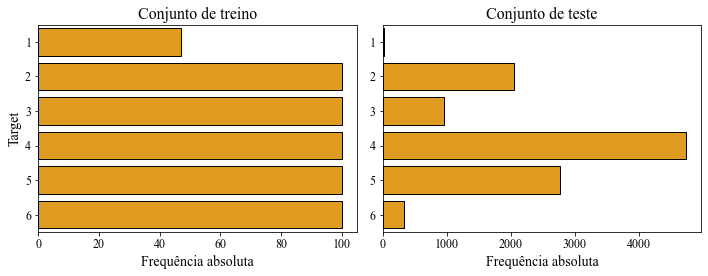

In [17]:
# layout dos plots
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# gráfico de barras dos dados de treino
sns.countplot(y = 'TARGET', data = train, color = col, edgecolor = ec, ax = axes[0])
axes[0].set_title("Conjunto de treino", size = fs_title)
axes[0].set_xlabel("Frequência absoluta", size = 14)
axes[0].set_ylabel("Target", size = 14)

# gráfico de barras dos dados de teste
sns.countplot(y = 'TARGET', data = test, color = col, edgecolor = ec, ax = axes[1])
axes[1].set_title("Conjunto de teste", size = fs_title)
axes[1].set_xlabel("Frequência absoluta", size = 14)
axes[1].set_ylabel("")

plt.tight_layout();

##### Visualização espacial dos dados de treino e teste

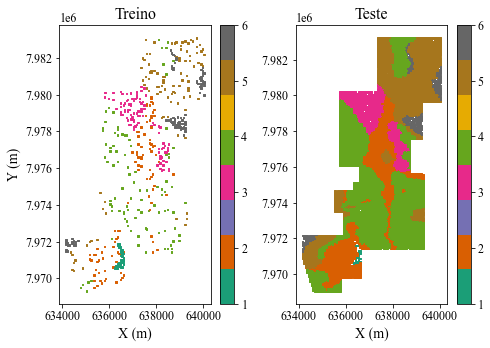

In [18]:
# layout dos plots
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (7, 5))

# Localização dos dados de treino
p1 = ax1.scatter(data = train, x = 'X', y = 'Y', c = 'TARGET', cmap = cm, s = sz, marker = mk)
fig.colorbar(p1, ax = ax1)
ax1.set_title('Treino', size = fs_title)
ax1.set_xlabel('X (m)', size = 14)
ax1.set_ylabel('Y (m)', size = 14)

# Localização dos dados de teste
p2 = ax2.scatter(data = test, x = 'X', y = 'Y', c = 'TARGET', cmap = cm, s = sz, marker = mk)
fig.colorbar(p2, ax = ax2)
ax2.set_title('Teste', size = fs_title)
ax2.set_xlabel('X (m)', size = 14)

plt.tight_layout();

### Escalonamento das features

#### StandardScaler

In [19]:
# normalização das features
X_train_std, X_test_std = featureScaling(X_train, X_test, method = StandardScaler())

In [20]:
# visualização das 5 primeiras linhas das features de treino normalizadas
pd.DataFrame(X_train_std, columns = df[FEAT].columns).head()

,GT,K,TH,U,CT,U_K,TH_K,U_TH,MDT,B01,...,B03,B04,B05,B06,B07,B08,B09,R,G,B
0,1.925042,0.294877,-0.315957,0.403014,0.080342,-0.570957,-0.613666,0.396018,-1.647478,-0.883643,...,-0.850956,-1.029210,-0.176277,-1.145369,-1.322683,-0.841989,-1.003773,-0.236750,1.247100,0.781578
1,-0.697592,-0.635175,1.709698,0.444511,0.357349,0.317860,1.654651,-1.175458,1.617799,-0.824130,...,-0.769237,-0.242417,-1.150729,-0.209394,-0.339503,-0.387236,0.658618,-0.965742,-0.301601,0.001767
2,0.564241,-0.305536,-0.422973,-0.316259,-0.462130,-0.272755,-0.446748,0.275135,-0.916880,-0.297013,...,-0.188918,-0.149952,-0.358138,0.092082,-0.017206,-0.427049,-0.528804,-0.008940,0.417998,0.086529
3,-0.669770,-0.258445,-0.945312,-0.583681,-0.519840,-0.382771,-0.247575,0.275135,1.040786,0.796330,...,0.963430,0.825973,0.468382,1.079967,1.151339,1.176975,3.587592,-0.282312,-0.817835,-0.540711
4,0.026334,-0.529220,-0.774596,-0.431527,-0.773763,-0.269859,-0.387077,-0.027072,-2.231456,-0.589478,...,-0.489737,-0.468536,-0.174241,-0.208596,-0.240436,-0.809254,-2.349518,-0.540497,-1.662581,-0.676330


#### MinMaxScaler

In [21]:
# escalonamento das features
X_train_mm, X_test_mm = featureScaling(X_train, X_test, method = MinMaxScaler())

In [22]:
# visualização das 5 primeiras linhas das features de treino normalizadas
pd.DataFrame(X_train_mm, columns = df[FEAT].columns).head()

,GT,K,TH,U,CT,U_K,TH_K,U_TH,MDT,B01,...,B03,B04,B05,B06,B07,B08,B09,R,G,B
0,0.315739,0.231306,0.192499,0.437019,0.325930,0.113918,0.040185,0.271429,0.155171,0.088440,...,0.110688,0.129058,0.355908,0.283608,0.204346,0.098803,0.301205,0.509881,0.812749,0.698413
1,0.030637,0.060203,0.671793,0.447825,0.397959,0.250000,0.317246,0.085714,0.811005,0.095588,...,0.120803,0.221694,0.229932,0.448935,0.380798,0.148837,0.554217,0.320158,0.418327,0.515873
2,0.167809,0.120847,0.167178,0.249725,0.184874,0.159574,0.060573,0.257143,0.301912,0.158905,...,0.192640,0.232581,0.332398,0.502186,0.438641,0.144456,0.373494,0.569170,0.601594,0.535714
3,0.033662,0.129511,0.043587,0.180090,0.169868,0.142730,0.084901,0.257143,0.695111,0.290237,...,0.335288,0.347486,0.439249,0.676682,0.648360,0.320938,1.000000,0.498024,0.286853,0.388889
4,0.109334,0.079696,0.083980,0.219710,0.103842,0.160018,0.067862,0.221429,0.037878,0.123775,...,0.155402,0.195071,0.356172,0.449076,0.398578,0.102404,0.096386,0.430830,0.071713,0.357143


#### RobustScaler

In [23]:
# escalonamento das features
X_train_rob, X_test_rob = featureScaling(X_train, X_test, method = RobustScaler())

In [24]:
# visualização das 5 primeiras linhas das features de treino normalizadas
pd.DataFrame(X_train_rob, columns = df[FEAT].columns).head()

,GT,K,TH,U,CT,U_K,TH_K,U_TH,MDT,B01,...,B03,B04,B05,B06,B07,B08,B09,R,G,B
0,2.702486,0.579235,0.043056,0.525253,0.312165,-0.328488,-0.438356,0.50,-1.590454,-0.660762,...,-0.586623,-0.832424,-0.025165,-0.934735,-0.970608,-0.674137,-0.666667,-0.173913,0.846939,0.523256
1,-0.423234,-0.284153,1.385395,0.555556,0.495792,0.563953,2.772831,-0.80,1.224634,-0.598760,...,-0.510965,-0.102884,-0.885560,-0.199247,-0.216216,-0.213357,0.500000,-0.637681,-0.163265,-0.011628
2,1.080649,0.021858,-0.027860,0.000000,-0.047437,-0.029070,-0.202055,0.40,-0.960585,-0.049601,...,0.026316,-0.017147,-0.185740,0.037653,0.031081,-0.253698,-0.333333,-0.028986,0.306122,0.046512
3,-0.390075,0.065574,-0.373997,-0.195286,-0.085692,-0.139535,0.079909,0.40,0.727175,1.089460,...,1.093202,0.887763,0.544038,0.813932,0.927703,1.371582,2.555556,-0.202899,-0.500000,-0.383721
4,0.439559,-0.185792,-0.260870,-0.084175,-0.254017,-0.026163,-0.117580,0.15,-2.093918,-0.354296,...,-0.252193,-0.312549,-0.023367,-0.198619,-0.140203,-0.640968,-1.611111,-0.367150,-1.051020,-0.476744


### Seleção de features

#### Teste f - ANOVA

In [25]:
# seleção das features (Teste f - ANOVA)
X_train_anova, X_test_anova, scores_anova = selectFeatures(X_train_std, y_train, X_test_std, f_classif, n_features = 10)

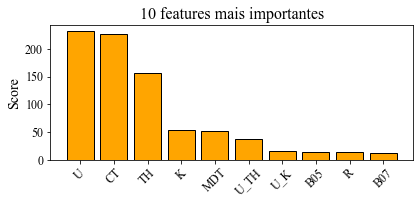

In [26]:
plotSelectionScores(scores_anova, k = 10)

In [27]:
# as 10 features "mais importantes" de acordo com o teste f (ANOVA)
anova_dic = dicScores(scores_anova, k = 10)
anova_dic

{'U': 231.94,
 'CT': 226.68,
 'TH': 155.98,
 'K': 53.82,
 'MDT': 51.09,
 'U_TH': 36.36,
 'U_K': 15.41,
 'B05': 14.08,
 'R': 13.93,
 'B07': 12.36}

#### Classificação por informação mútua

In [28]:
# seleção das features (informação mútua)
X_train_mut, X_test_mut, scores_mut = selectFeatures(X_train_std, y_train, X_test_std, mutual_info_classif, n_features = 10)

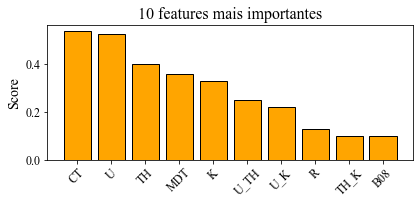

In [29]:
plotSelectionScores(scores_mut, k = 10)

In [30]:
# as 10 features "mais importantes" de acordo com a classificação por informação mútua
mutual_info_dic = dicScores(scores_mut, k = 10)
mutual_info_dic

{'CT': 0.54,
 'U': 0.53,
 'TH': 0.4,
 'MDT': 0.36,
 'K': 0.33,
 'U_TH': 0.25,
 'U_K': 0.22,
 'R': 0.13,
 'TH_K': 0.1,
 'B08': 0.1}

### Oversampling

#### SMOTE

In [31]:
# oversampling dos dados de treino
X_train_smt, y_train_smt = SMOTE().fit_resample(X_train_anova, y_train)

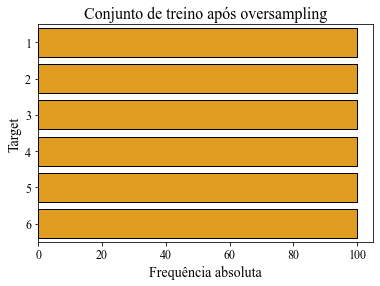

In [32]:
# transformação de narray em dataframe
train_smt = pd.DataFrame(X_train_smt, columns = anova_dic.keys())
train_smt['TARGET'] = y_train_smt

# gráfico de barras
sns.countplot(y = 'TARGET', data = train_smt, color = col, edgecolor = ec)

# título e labels do gráfico
plt.title("Conjunto de treino após oversampling", size = fs_title)
plt.xlabel("Frequência absoluta", size = 14)
plt.ylabel("Target", size = 14);

<a id='4'></a>
## Modelagem dos dados

### Divisão entre treino e teste

In [33]:
# dados de treino e teste
X_train, y_train, X_test, y_test = customTrainTestSplit(df, threshold = 100)

print(f"Treino: X {X_train.shape}, y {y_train.shape}")
print(f"Teste: X {X_test.shape}, y {y_test.shape}")

Treino: X (547, 21), y (547,)
Teste: X (10871, 21), y (10871,)


### Criação de pipelines

Os pipelines abaixo são constituídos pelas seguintes etapas:

1. Escalonamento das features

2. Seleção das features mais importantes

3. Oversampling

4. Instanciação do classificador

In [34]:
# regressão logística multinomial (mlr)
mlr_pipe = Pipeline(steps = [('scaler', StandardScaler()),
                             ('selector', SelectKBest(k = 10)),
                             ('smote', None),
                             ('clf', LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', random_state = 42))])

# gaussian naive bayes (gnb)
gnb_pipe = Pipeline(steps = [('scaler', StandardScaler()),
                             ('selector', SelectKBest(k = 10)),
                             ('smote', None),
                             ('clf',GaussianNB())])

# K-nearest neighbor (knn)
knn_pipe = Pipeline(steps = [('scaler', StandardScaler()),
                             ('selector', SelectKBest(k = 10)),
                             ('smote', None),
                             ('clf',KNeighborsClassifier())])

# support vector classifier (svc)
svc_pipe = Pipeline(steps = [('scaler', StandardScaler()),
                             ('selector', SelectKBest(k = 10)),
                             ('smote', None),
                             ('clf', SVC(random_state = 42))])

# random forest (rf)
rf_pipe = Pipeline(steps = [('scaler', StandardScaler()),
                             ('selector', SelectKBest(k = 10)),
                             ('smote', None),
                             ('clf', RandomForestClassifier(random_state = 42))])

# xgboost classifier (xgb)
xgb_pipe = Pipeline(steps = [('scaler', StandardScaler()),
                             ('selector', SelectKBest(k = 10)),
                             ('smote', None),
                             ('clf', XGBClassifier(random_state = 42, eval_metric = 'mlogloss'))])

In [35]:
# dicionário dos pipelines
pipe = {"MLR" : mlr_pipe,
        "GNB" : gnb_pipe,
        "KNN" : knn_pipe,
        "SVC" : svc_pipe,
        "RF"  : rf_pipe,
        "XGB" : xgb_pipe}

### Treinamento dos classificadores

In [36]:
# treinamento dos classificadores
for p in pipe.keys():
    pipe[p].fit(X_train, y_train)

<a id='4'></a>
## Validação cruzada

In [37]:
# número de folds
n_folds = 4

# métrica utilizada na validação cruzada
metric = 'f1_weighted'

In [ ]:
# validação cruzada dos classificadores
for p in pipe.keys():
    cv = customKFoldCV(pipe[p], X_train, y_train, n_folds = n_folds, metric = metric)
    μ = round(cv.mean(), 2)
    σ = round(cv.std(), 2)
    print('----')
    print("{0} - {1}:".format(p, metric))
    print(cv)
    print("μ = {0} \t σ = {1}".format(μ, σ))

----
MLR - f1_weighted:
[0.66912219 0.51745794 0.55292915 0.59426879]
μ = 0.58 	 σ = 0.06
----
GNB - f1_weighted:
[0.51696414 0.53835134 0.56242829 0.51045346]
μ = 0.53 	 σ = 0.02
----
KNN - f1_weighted:
[0.56495305 0.57796375 0.59814533 0.53296503]
μ = 0.57 	 σ = 0.02
----
SVC - f1_weighted:
[0.59299417 0.62550653 0.63003516 0.55127939]
μ = 0.6 	 σ = 0.03
----
RF - f1_weighted:
[0.74520481 0.73813131 0.6878177  0.61636989]
μ = 0.7 	 σ = 0.05


<a id='5'></a>
## Tuning dos modelos

In [43]:
# criação de um pipeline de inicialização
init_pipe = Pipeline([('clf', LogisticRegression())])

# parâmetros de tuning dos modelos
gs_param = [
            {'clf' : [LogisticRegression()],
             'clf__penalty' : ['l2', 'l1'],
             'clf__C' : [1,7.74,59.9,1290],
             'clf__multi_class' : ['multinomial'],
             'clf__solver' : ['lbfgs'],
             'clf__random_state' : [42]},
    
            {'clf' : [LogisticRegression()],
             'clf__penalty' : ['l2'],
             'clf__C' : [1,7.74,59.9,1290],
             'clf__solver' : ['newton-cg', 'saga', 'sag', 'liblinear'],
             'clf__multi_class' : ['multinomial'],
             'clf__solver' : ['lbfgs'],
             'clf__random_state' : [42]},
    
            {'clf' : [GaussianNB()],
             'clf__var_smoothing' : [1,0.1,0.0001,0.0000001]},
    
            {'clf' :[KNeighborsClassifier()],
             'clf__n_neighbors' : [3,7,11,15,19],
             'clf__weights' : ['uniform', 'distance'],
             'clf__metric' : ['minkowski', 'chebyshev']},
    
            {'clf' : [SVC()],
             'clf__C' : [0.5,2,16,64,128],
             'clf__gamma' : [0.001, 0.01, 0.1, 1, 10, 100],
             'clf__kernel' : ['poly', 'rbf'],
             'clf__random_state' : [42]},
    
            {'clf' : [RandomForestClassifier()],
             'clf__n_estimators' : [100,250,500],
             'clf__random_state' : [42]},
    
            {'clf' : [XGBClassifier()],
             'clf__n_estimators' : [100,250,500],
             'clf__learning_rate' : [0.05,0.1],
             'clf__metric_eval' : ['mlogloss'],
             'clf__random_state' : [42]}
]

In [ ]:
# instanciamento do grid search
gridsearch = GridSearchCV(init_pipe, gs_param, cv = 4, scoring = metric, verbose = 0, n_jobs = -1)

# treinando o grid search
#best_model = gridsearch.fit(X_train, y_train)

In [ ]:
# visualizando resultados
# best_model_score = best_model.score(X_test, y_test)
# print(best_model.best_estimator_)
# print()
# print(metric, ':', round(best_model_score, 2))